<a href="https://colab.research.google.com/github/smitbajaj/phillies-learning/blob/main/hierarchical_fonnesbeck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up & Organizing

In [1]:
!git clone https://github.com/fonnesbeck/hierarchical_models_sports_analytics.git

Cloning into 'hierarchical_models_sports_analytics'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 7), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 6.57 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor.tensor as pt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.19.1


In [3]:
baseball_data = pl.read_csv('/content/hierarchical_models_sports_analytics/data/batter_data.csv')

In [4]:
# -- filters out 2023, adds a "label" column (uniqueId), drops nulls

fitting_subset = baseball_data.filter(pl.col("season") < 2023) # filtering out 2023 & higher

fitting_subset = fitting_subset.with_columns(
    pl.concat_str([
        pl.col("name"),
        pl.col("season"),
        pl.col("team")
    ], separator=" - ").alias("label")
).drop_nulls()

In [5]:
fitting_subset = fitting_subset.with_columns(
    (pl.col("hr") / pl.col("num_pa")).alias("hr_rate")
)

<Axes: ylabel='Density'>

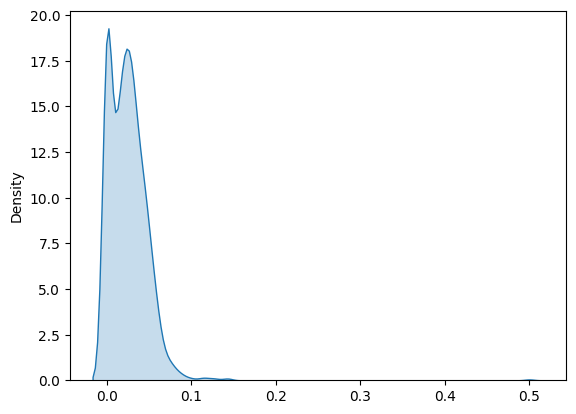

In [6]:
hr_rate_data = fitting_subset["hr_rate"].to_numpy()
sns.kdeplot(hr_rate_data,fill=True)

## Modeling

In [7]:
fitting_subset_pandas = fitting_subset.to_pandas()

pa = fitting_subset_pandas['num_pa'].to_numpy()
hr = fitting_subset_pandas['hr'].to_numpy()

coords = {'batter': fitting_subset_pandas['label'].to_numpy()} # - batters & indiv seasons

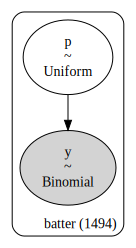

In [8]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform('p', 0, 1, dims='batter') # absolutely uninformed prior -- could be anything b/w 0 and 1

    y = pm.Binomial('y', n=pa, p=p, observed=hr, dims='batter') # n: num_samples/PAs
                                                                # p: probability of success for each trial
                                                                # observed: how many successes were observed
                                                                # dimensions: len(fitting_subset_pandas['label'].to_numpy())
pm.model_to_graphviz(uninformative_prior_model)

### Prior Predictive Sampling

* In experimenting with 1 sample: run below & the one following: will note that when:

* `p = pm.Uniform('p', 0, 1, dims='batter')` then we actually take 1 sample for each batter (so 1554 dimensions) whereas `p = pm.Uniform('p', 0, 1)` is just one sample applied to all batters

In [90]:
with pm.Model(coords=coords) as uninformative_prior_model:
  p = pm.Uniform('p', 0, 0.3, dims='batter') # absolutely uninformed prior -- could be anything b/w 0 and 1
  # p = pm.Uniform('p', 0, 1) # absolutely uninformed prior -- could be anything b/w 0 and 1
  y = pm.Binomial('y', n=pa, p=p, observed=hr, dims='batter') # n: num_samples/PAs
  uninformed_prior_trace = pm.sample_prior_predictive(1)

<Axes: >

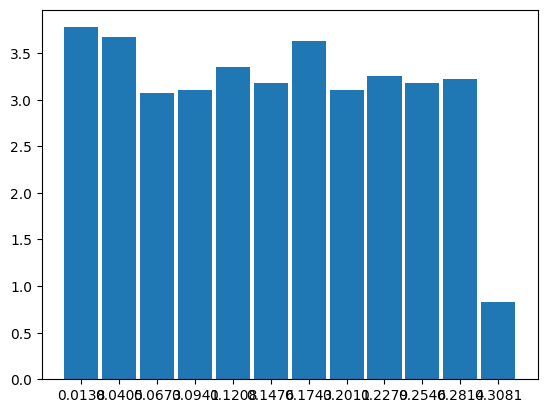

In [91]:
az.plot_dist(uninformed_prior_trace.prior['p'], kind="hist")

### Conditioning on Data



*   TBD: autocorrelation



In [ ]:
with uninformative_prior_model:
  trace = pm.sample(draws=1000, tune=1000, cores=4, chains=4, random_seed=RANDOM_SEED)

posterior = az.summary(trace)

Output()

In [ ]:
posterior['pa'] = pa
posterior.head(3)


*   mean, sd, hdi_3%, hdi_97% — self-explanatory
*   mcse_mean, mcse_sd — in practice, make close to 0. represents the uncertainity in some of those metrics ... monte carlo standard error



In [ ]:
# model is expressing uncertainity in its own estimates (based on convergence here).. uncertainity in mean and standard deviation
# -- clearly correlated to low PA's which logically tracks, low PAs = higher uncertainity
posterior.sort_values(by='mcse_mean',ascending=False).head(5)

In [ ]:
# model is fairly uncertain up until roughly 50 plate appearances - tracks. wonder how that changes with different priors (if at all)
posterior[posterior['mcse_mean'] > 0]['pa'].describe()

In [ ]:
random_batters = np.random.choice(coords['batter'], size=2, replace=False)

for batter in random_batters:

  num_pa = fitting_subset_pandas[fitting_subset_pandas['label'] == batter]['num_pa'].values[0]

  az.plot_posterior(
      trace,
      var_names=["p"],
      coords={"batter": [batter]},
      hdi_prob=0.94,
      figsize=(8, 4))
  plt.title(f"{batter}: {num_pa} PAs")
  plt.show()